# Multimodal Correlation Analysis: Flags, Anthem Text, and Anthem Audio

In this notebook, we investigate whether there exist correlations between three different data modalities:

- **Visual (Flags):** We extract visual features (e.g., aspect ratio) from national flag images.
- **Textual (Anthem Translations):** We analyze the English translations of national anthems, computing sentiment scores as a proxy for tone.
- **Audio (Anthem Music):** We extract audio features (e.g., tempo) from the anthem audio files.

## Methodology Overview:

### 1. Data Loading and Preprocessing
- **Flags:** Load flag images from `flags_png/` and compute each flag's aspect ratio.
- **Anthem Translations:** Load the English translations from `anthem_translations.json`, preprocess the text, and compute sentiment scores using VADER.
- **Anthem Audio:** Load audio files from `anthem_mp3/` and estimate the tempo (beats per minute).

### 2. Feature Integration
- Combine the features from the three modalities for each country into a unified DataFrame.

### 3. Correlation Analysis
- Compute correlation statistics and visualize the relationships between:
   - Flag aspect ratio vs. Anthem sentiment score.
   - Anthem sentiment score vs. Anthem tempo.
   - Flag aspect ratio vs. Anthem tempo.

### 4. Visualization
- Create scatter plots and a correlation matrix to support our exploratory analysis.
### 5. Multimodal Generative Model
- Try to implement a VAE to generate anthem text based on input flag image

**Note:** This analysis is exploratory in nature. The correlations may reveal interesting patterns or insights into national identity, historical influences, and cultural expression.

---

## 1. Data Loading and Preprocessing

We first load data from each modality.

### A. Flag Images: Aspect Ratio

We load the flag images from the folder `flags_png/` (assumed to be stored with filenames like "US.png", "IN.png", etc.).
For each flag, we compute its aspect ratio (width/height). If the flag is not in landscape orientation, we swap dimensions.

In [1]:

import os
from PIL import Image
import pandas as pd

# Directory containing flag images
flags_dir = "flags_png"

# List all PNG files in the directory
flag_files = [f for f in os.listdir(flags_dir) if f.endswith('.png')]

# Create a dictionary to store aspect ratios (key: country code, value: aspect ratio)
flag_features = {}

for file in flag_files:
    file_path = os.path.join(flags_dir, file)
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            # Ensure landscape orientation: use larger value as width
            if width < height:
                width, height = height, width
            aspect_ratio = width / height
            country = file.split('.')[0].upper()
            flag_features[country] = aspect_ratio
    except Exception as e:
        print(f"Error processing {file}: {e}")

print("Extracted flag aspect ratios for", len(flag_features), "countries.")


C:\Users\iitia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Extracted flag aspect ratios for 256 countries.


### B. Anthem Translations: Sentiment Analysis

- We load the anthem translations from `anthem_translations.json` and use NLTK's VADER to compute a sentiment score.
- We use the compound score as an overall sentiment indicator.

In [2]:

import json
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure necessary NLTK data is downloaded
nltk.download('vader_lexicon')

# Load anthem translations JSON file
with open("anthem_translations.json", "r", encoding="utf-8") as f:
    anthem_translations = json.load(f)

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Dictionary to store sentiment scores (key: country code, value: compound sentiment)
anthem_sentiments = {}

for country, text in anthem_translations.items():
    # Preprocess text: convert to lowercase and remove punctuation
    text_clean = text.lower()
    text_clean = re.sub(r'[^a-z\s]', '', text_clean)
    sentiment = sia.polarity_scores(text_clean)
    anthem_sentiments[country.upper()] = sentiment['compound']

print("Computed sentiment scores for", len(anthem_sentiments), "countries.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\iitia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Computed sentiment scores for 228 countries.



## **C. Anthem Audio: Tempo Estimation**

- We load the anthem audio files from `anthem_mp3/` and estimate their tempo (in BPM) using librosa.


In [3]:

import librosa

audio_dir = "anthem_mp3"
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.mp3')]

# Dictionary to store tempo (key: country code, value: tempo in BPM)
anthem_tempos = {}

for file in audio_files:
    file_path = os.path.join(audio_dir, file)
    try:
        # Load audio (preserving the original sampling rate)
        y, sr = librosa.load(file_path, sr=None)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        country = file.split('.')[0].upper()
        anthem_tempos[country] = float(tempo)
    except Exception as e:
        print(f"Error processing {file}: {e}")

print("Estimated tempos for", len(anthem_tempos), "anthem audio files.")


C:\Users\iitia\AppData\Local\Temp\ipykernel_15140\821819790.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  anthem_tempos[country] = float(tempo)


Estimated tempos for 49 anthem audio files.



## 2. Feature Integration

- Next, we combine the extracted features from the three modalities into a single DataFrame.
- **Note:** We consider only the countries that have data available in all three modalities. We take the intersection of keys from our dictionaries.


In [4]:

# Get sets of countries for each modality
countries_flags = set(flag_features.keys())
countries_text = set(anthem_sentiments.keys())
countries_audio = set(anthem_tempos.keys())

# Compute the intersection: only keep countries present in all modalities
common_countries = countries_flags & countries_text & countries_audio
print("Number of countries with data in all modalities:", len(common_countries))

# Create a DataFrame for integrated features
data = []
for country in common_countries:
    data.append({
        "Country": country,
        "Aspect_Ratio": flag_features[country],
        "Sentiment": anthem_sentiments[country],
        "Tempo": anthem_tempos[country]
    })

df_multimodal = pd.DataFrame(data)
print("Integrated Feature Data:")
display(df_multimodal.head())


Number of countries with data in all modalities: 48
Integrated Feature Data:


,Country,Aspect_Ratio,Sentiment,Tempo
0,PE,1.497006,-0.8689,92.285156
1,SE,1.602564,0.9756,63.802083
2,TR,1.497006,0.9975,83.354335
3,BR,1.428571,0.9948,123.046875
4,CH,1.000000,0.9892,103.359375


## 3. Correlation Analysis

We now analyze the relationships between the three features:

- **Flag Aspect Ratio**
- **Anthem Sentiment Score** (compound score from VADER)
- **Anthem Tempo (BPM)**

We compute the Pearson correlation coefficient between these features and visualize the correlation matrix.

Correlation Matrix:


,Aspect_Ratio,Sentiment,Tempo
Aspect_Ratio,1.000000,-0.14795,0.048505
Sentiment,-0.147950,1.00000,-0.203450
Tempo,0.048505,-0.20345,1.000000


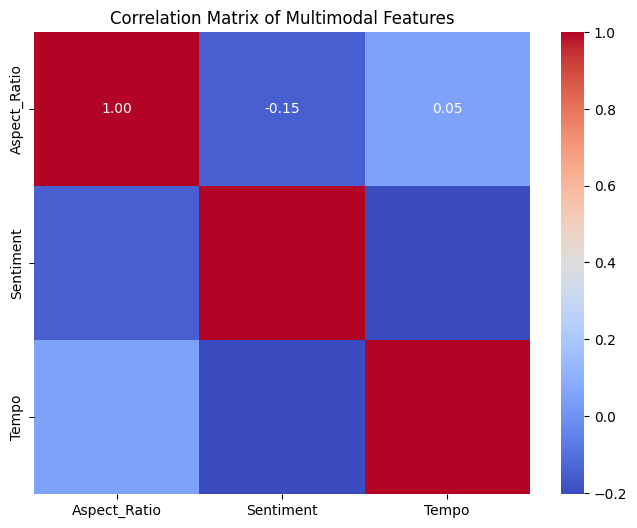

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df_multimodal[["Aspect_Ratio", "Sentiment", "Tempo"]].corr()
print("Correlation Matrix:")
display(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Multimodal Features")
plt.show()


## 4. Scatter Plot Analysis

We create scatter plots to visualize pairwise relationships between the features.

**Examples:**

- **Aspect Ratio vs. Sentiment:**  
  Does the design of a flag (as indicated by its aspect ratio) relate to the tone of its anthem?

- **Sentiment vs. Tempo:**  
  Are anthems with higher (or lower) sentiment scores associated with faster (or slower) tempos?

- **Aspect Ratio vs. Tempo:**  
  Is there any link between flag design and the musical pace of anthems?

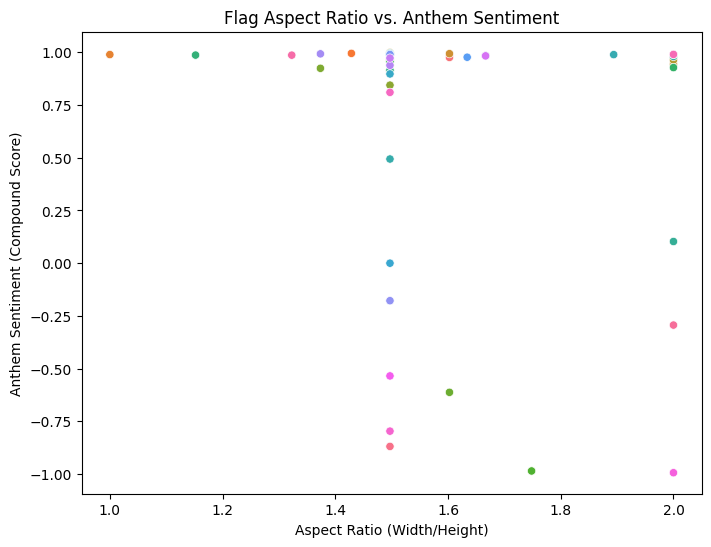

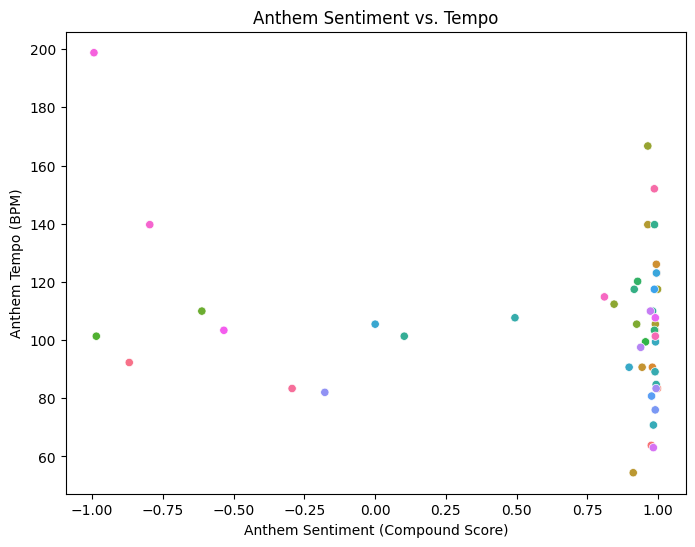

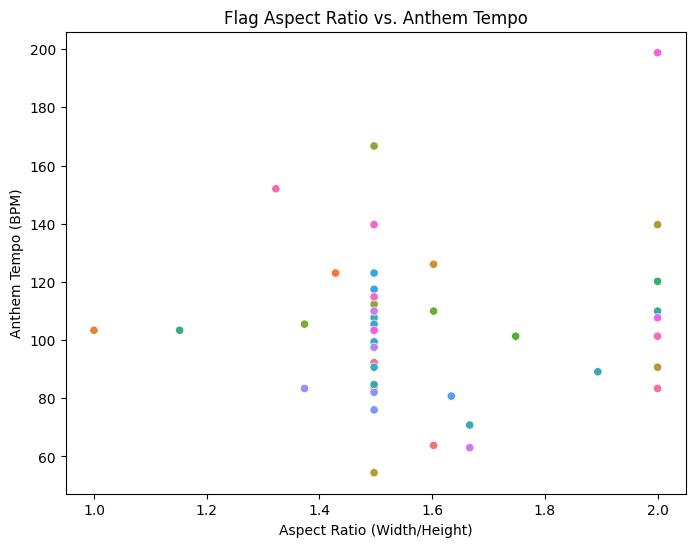

In [6]:

# Scatter Plot: Aspect Ratio vs. Sentiment
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_multimodal, x="Aspect_Ratio", y="Sentiment", hue="Country", legend=False)
plt.title("Flag Aspect Ratio vs. Anthem Sentiment")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Anthem Sentiment (Compound Score)")
plt.show()

# Scatter Plot: Sentiment vs. Tempo
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_multimodal, x="Sentiment", y="Tempo", hue="Country", legend=False)
plt.title("Anthem Sentiment vs. Tempo")
plt.xlabel("Anthem Sentiment (Compound Score)")
plt.ylabel("Anthem Tempo (BPM)")
plt.show()

# Scatter Plot: Aspect Ratio vs. Tempo
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_multimodal, x="Aspect_Ratio", y="Tempo", hue="Country", legend=False)
plt.title("Flag Aspect Ratio vs. Anthem Tempo")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Anthem Tempo (BPM)")
plt.show()


## 8. Important Remarks:

**Aspect Ratio vs. Sentiment (r = –0.15):**  
Slight negative correlation; more elongated flags tend to have marginally lower anthem sentiment, but the effect is weak.

**Aspect Ratio vs. Tempo (r = 0.05):**  
No meaningful relationship between flag shape and anthem tempo.

**Sentiment vs. Tempo (r = –0.20):**  
Modest negative correlation; anthems with more negative sentiment may be slightly faster, though the association is weak.

### Potential Insights :

- The weak correlations indicate that flag aspect ratio, anthem sentiment, and tempo do not share strong linear relationships with the current features.
- The modest negative correlation between sentiment and tempo suggests that more somber anthems might be slightly faster, warranting further exploration into underlying rhythmic patterns and cultural influences.

### Next Steps :

#### Feature Expansion:
- **Visual:** Enrich flag analysis with additional features (e.g., color distribution, symbolic elements,CNN features).
- **Textual:** Enhance text analysis using techniques like topic modeling and n-gram extraction.
- **Audio:** Incorporate further features (e.g., MFCC similarity, key detection, dynamic range).

#### Advanced Methods:
- Employ machine learning and multivariate analysis to detect non-linear patterns beyond simple correlations.

#### Validation & Context:
- Collaborate with historians, musicologists, and cultural experts to interpret findings and integrate historical or cultural context.

These steps lay the groundwork for deeper multimodal research into the interplay between national symbols, lyrical sentiment, and musical tempo.


## 9. Multimodal Generative Model 

Now, we explore a multimodal generative model that learns a joint latent space between
flag features (extracted via a pre-trained CNN) and anthem text features.

**Workflow:**

1. **Flag Feature Extraction:**  
   Use a pre-trained VGG16 to extract a high-dimensional feature vector from each flag image.

2. **Anthem Text Features:**  
   We would extract these features via topic modeling, TF-IDF, or other NLP techniques

3. **Conditional Generative Model:**  
   Build a Conditional Variational Autoencoder (VAE) that maps flag features to anthem text features.

4. **Training and Inference:**  
   Train the VAE on the paired data and then generate anthem features from a given flag image.

*Note: In a real application, you would replace the synthetic anthem features with your actual extracted features.*

In [13]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### 9.1. Flag Feature Extraction using CNN (VGG16)
- We load pre-trained VGG16, remove its classifier, and use the convolutional feature extractor to obtain a 
   feature vector for each flag image. VGG16 outputs a tensor of shape (1, 512, 7, 7) from which we flatten to a vector of size 25088.

- The images are resized to 224x224 and normalized using standard ImageNet parameters.


In [15]:
from tqdm import tqdm
# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
vgg16 = vgg16.to(device)

# Define a feature extractor that uses VGG16's convolutional layers and avgpool
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(VGG16FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # shape: (batch, 512, 7, 7)
        x = torch.flatten(x, 1)  # shape: (batch, 25088)
        return x

feature_extractor = VGG16FeatureExtractor(vgg16).to(device)

# Define image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Directory containing flag images (assumes filenames like "US.png", "IN.png", etc.)
flags_dir = "flags_png"
flag_files = [f for f in os.listdir(flags_dir) if f.endswith('.png')]

# Extract CNN features for each flag
print("Extraction starts:")
flag_features_dict = {}
for file in tqdm(flag_files, desc="Extracting flag features"):
    try:
        image_path = os.path.join(flags_dir, file)
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = feature_extractor(img_tensor)
        features_np = features.cpu().numpy().squeeze()  # shape: (25088,)
        country = file.split('.')[0].upper()
        flag_features_dict[country] = features_np
    except Exception as e:
        print(f"Error processing {file}: {e}")


print("Extracted CNN features for", len(flag_features_dict), "flag images.")

Extraction starts:


Extracting flag features: 100%|██████████████████████████████████████████████████████| 256/256 [01:44<00:00,  2.45it/s]

Extracted CNN features for 256 flag images.


### 9.2. Anthem Text Features

- we would extract these features via topic modeling, TF-IDF, or other NLP techniques.

In [34]:
import json
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load anthem translations from the JSON file
with open("anthem_translations.json", "r", encoding="utf-8") as f:
    anthem_translations = json.load(f)

# Convert keys in anthem_translations to uppercase for consistency
anthem_translations_upper = {k.upper(): v for k, v in anthem_translations.items()}

# Preprocessing function: lowercase, remove non-alphabetic characters, and extra spaces
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Assume flag_features_dict is already defined from flag CNN extraction.
# We only extract anthem features for countries that have flag features.
countries = list(flag_features_dict.keys())

# Build the documents list, filtering by countries that have an anthem translation available.
documents = []
countries_filtered = []
for country in countries:
    country_key = country.upper()  # Ensure the country code is in uppercase
    if country_key in anthem_translations_upper:
        processed_text = preprocess_text(anthem_translations_upper[country_key])
        documents.append(processed_text)
        countries_filtered.append(country_key)

print(f"Extracting anthem features for {len(documents)} countries.")

# Create TF-IDF matrix from the documents
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(documents)

print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Reduce the TF-IDF features to 20 dimensions using Truncated SVD
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
anthem_features_reduced = svd.fit_transform(tfidf_matrix)

print("Reduced anthem features shape:", anthem_features_reduced.shape)

# Create a dictionary mapping each country to its 20-dimensional anthem feature vector
anthem_text_features_dict = {}
for i, country in enumerate(countries_filtered):
    anthem_text_features_dict[country] = anthem_features_reduced[i]

# Example: Display the feature vector for one country
if countries_filtered:
    sample_country = countries_filtered[0]
    print(f"Anthem features for {sample_country}:")
    print(anthem_text_features_dict[sample_country])
else:
    print("No countries with matching anthem translations found.")


Extracting anthem features for 228 countries.
TF-IDF matrix shape: (228, 3894)
Reduced anthem features shape: (228, 50)
Anthem features for AD:
[ 0.09802485  0.00650333 -0.03087962 -0.045021    0.00178727  0.00713596
 -0.04850346 -0.03730409 -0.07690495 -0.07298138  0.01471234 -0.02134433
  0.08428249  0.02845756  0.0371708   0.04838837  0.10214384 -0.05122312
 -0.13269994 -0.0033778   0.043104    0.00618156 -0.03211991  0.15265327
 -0.13836917 -0.00407422  0.06555674 -0.03186014 -0.01838064  0.01840918
 -0.04859675 -0.06036152  0.03537894 -0.09344125 -0.07218755 -0.00650795
 -0.00608266  0.18602835  0.07428991 -0.08046062  0.01351952 -0.04322287
  0.00225003 -0.02343933 -0.08883436  0.04413803  0.09587081  0.09105054
  0.24418886 -0.07899928]


### 9.3. Data Preparation for Conditional VAE
- We prepare the paired dataset for countries where we have both CNN-extracted flag features and anthem text features.
- The flag feature dimension is 25088 (from VGG16), and the anthem feature dimension is 20.


In [37]:
# Compute the common countries between flag features and anthem text features
common_countries = list(set(flag_features_dict.keys()).intersection(anthem_text_features_dict.keys()))

# Extract the features for these common countries
flag_features = np.array([flag_features_dict[c] for c in common_countries])
anthem_features = np.array([anthem_text_features_dict[c] for c in common_countries])

print("Number of common countries:", len(common_countries))
print("Flag features shape:", flag_features.shape)       # Expected: (num_samples, 25088)
print("Anthem features shape:", anthem_features.shape)     # Expected: (num_samples, 20)


Number of common countries: 228
Flag features shape: (228, 25088)
Anthem features shape: (228, 50)


### 9.4. Conditional VAE: Mapping Flag Features to Anthem Text Features
- We define a conditional VAE model with:
    - **Encoder:** Maps flag features to a latent space (latent dimension chosen as 64).
    - **Decoder:** Generates anthem text features from the latent representation.


In [38]:

# Define the encoder for flag features
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
    
    def forward(self, x):
        h = self.fc(x)
        return self.mu(h), self.logvar(h)

# Define the decoder to generate anthem text features
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, z):
        return self.fc(z)

# Define the Conditional VAE combining encoder and decoder
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

flag_input_dim = flag_features.shape[1]  # 25088 from CNN
latent_dim = 64
anthem_feature_dim=anthem_features.shape[1]
anthem_output_dim = anthem_feature_dim   # 20

model = ConditionalVAE(flag_input_dim, anthem_output_dim, latent_dim).to(device)


### 9.5. Training the Conditional VAE
- We use a loss function that combines the Mean Squared Error (reconstruction loss) and the KL divergence loss to regularize the latent space.


In [39]:
def loss_function(recon, target, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, target, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Convert data to PyTorch tensors
flag_tensor = torch.tensor(flag_features, dtype=torch.float32).to(device)
anthem_tensor = torch.tensor(anthem_features, dtype=torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    recon, mu, logvar = model(flag_tensor)
    loss = loss_function(recon, anthem_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}")



Epoch 10/200, Loss: 128.25
Epoch 20/200, Loss: 110.69
Epoch 30/200, Loss: 99.14
Epoch 40/200, Loss: 92.97
Epoch 50/200, Loss: 86.32
Epoch 60/200, Loss: 83.69
Epoch 70/200, Loss: 81.91
Epoch 80/200, Loss: 80.70
Epoch 90/200, Loss: 80.63
Epoch 100/200, Loss: 79.82
Epoch 110/200, Loss: 79.90
Epoch 120/200, Loss: 79.62
Epoch 130/200, Loss: 79.00
Epoch 140/200, Loss: 79.18
Epoch 150/200, Loss: 79.57
Epoch 160/200, Loss: 79.08
Epoch 170/200, Loss: 78.61
Epoch 180/200, Loss: 78.54
Epoch 190/200, Loss: 78.05
Epoch 200/200, Loss: 78.33


### 9.6. Inference: Generating Anthem Features from Flag Features

- After training, we can use the model to generate anthem text features from a given flag image.


In [41]:
# Choose a specific flag from our dataset (e.g., "US" if available, otherwise the first available flag)
country_code = "US" if "US" in flag_features_dict else list(flag_features_dict.keys())[0]
print(f"Using flag features for country: {country_code}")

# Convert the selected flag's feature vector to a PyTorch tensor
sample_flag_feature = torch.tensor(flag_features_dict[country_code], dtype=torch.float32).unsqueeze(0).to(device)

# Evaluate the model using the real flag features
model.eval()
with torch.no_grad():
    generated_anthem_feature, _, _ = model(sample_flag_feature)
    print(f"Generated Anthem Feature Vector (from flag {country_code}):")
    generated = generated_anthem_feature.cpu().numpy()
    print(generated)
    
# Use "US" as the sample country for the original anthem features
sample_country = "US"
print(f"Anthem features for {sample_country}:")
original = anthem_text_features_dict[sample_country]
print(original)

# Compute Euclidean distance between the generated and original feature vectors
euclidean_distance = np.linalg.norm(generated - original)
print(f"Euclidean distance between generated and original anthem features for {sample_country}: {euclidean_distance:.4f}")

# Compute cosine similarity between the generated and original feature vectors
cosine_similarity = np.dot(generated.flatten(), original) / (np.linalg.norm(generated.flatten()) * np.linalg.norm(original))
print(f"Cosine similarity between generated and original anthem features for {sample_country}: {cosine_similarity:.4f}")


Using flag features for country: US
Generated Anthem Feature Vector (from flag US):
[[ 1.7151870e-01  1.1681246e-02 -9.0513006e-04 -4.9238838e-04
   4.6428442e-03  5.3954246e-03 -1.3943499e-02 -2.7549081e-04
  -1.2670504e-03 -1.0410687e-02  3.7735568e-03  2.1585384e-03
   9.5365942e-04 -7.0372522e-03  5.2326480e-03 -3.6658819e-03
  -7.0189936e-03  1.4699530e-04  1.9830652e-05 -2.1993741e-04
  -4.4302372e-03 -2.3103096e-03 -9.2147924e-03  1.1903699e-03
  -7.5171217e-03 -5.3802095e-03  5.0895326e-03  3.4193210e-03
  -5.8389376e-03  4.6754740e-03 -5.2341530e-03  1.7708436e-02
  -4.1274093e-03 -3.2084621e-03  1.1582559e-03  2.5184397e-03
  -8.6963838e-03 -1.2640467e-02 -6.3948687e-03  4.9044304e-03
   1.2525893e-02  1.1627292e-02 -2.3566177e-03 -2.2244328e-03
   6.9275685e-04 -1.2827741e-02  7.2541535e-03 -5.5585988e-03
   4.9586538e-03  1.6403728e-03]]
Anthem features for US:
[ 0.22509769  0.01546112 -0.00799116 -0.16336491  0.1965728  -0.04142375
 -0.06911315 -0.02252521  0.02284189 -0.0

# Conclusion

- **Generated vs. Original Anthem Features:**  
  The generated anthem feature vector (derived from the US flag features) differs from the original TF-IDF-based anthem feature vector.  
  - **Euclidean Distance:** 0.6235  
  - **Cosine Similarity:** 0.3031

- **Interpretation:**  
  These quantitative metrics indicate that the current generative model's mapping from flag features to anthem text features is not very close.  
  - A **Euclidean distance** of 0.6235 suggests a noticeable difference in the feature space.  
  - A **cosine similarity** of 0.3031 (where 1.0 would be identical) further confirms that the generated and original features have low directional alignment.

- **Implications:**  
  The weak alignment between the generated and original features implies that:
  - The current model architecture and training may require further refinement.
  - More comprehensive feature extraction (both from flags and anthem texts) could enhance the mapping.
  - Additional data, more advanced models (e.g., conditional GANs or transformer-based approaches), and deeper integration of multimodal cues might be necessary to improve cross-modal generation.

- **Next Steps:**  
  - **Feature Enhancement:** Incorporate richer visual features (e.g., color histograms, symbolic elements) and more nuanced text representations (e.g., topic models or contextual embeddings).
  - **Model Improvement:** Experiment with advanced generative frameworks and non-linear mapping techniques.
  - **Validation:** Work with domain experts to validate the cultural and historical relevance of the generated outputs.

Overall, while this preliminary study establishes a framework for cross-modal generation between flag images and anthem texts, significant work remains to achieve a robust and meaningful multimodal generative model.
